In [70]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.covariance import EmpiricalCovariance
import torch
#from training import register_esmart_wip,get_cfg,build_detection_test_loader
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.structures import Boxes,Instances
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
import cv2
import copy
from detectron2.layers import batched_nms

embed_classwise = {}
fea_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/coco_features/gt/box"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def register_esmart_wip(root = "/home/mila/v/vaibhav.jade/scratch/intern/stud/datasets/esmart/"):
        things_classes = [
                        "bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"
                          ]
        name = 'esmart_wip'
        metadata = {"thing_classes":things_classes}
        register_coco_instances(
                        name,
                        metadata,
                        os.path.join(root, 'labels.json'),
                        os.path.join(root, 'data/'),
                    )
for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

def sample_estimator(embed_classwise,num_classes):
    classwise_mean = np.zeros((num_classes,embed_classwise[0][0].shape[0]),dtype='float32')
    precision = []
    X = None
    group_lasso = EmpiricalCovariance(assume_centered=False)
    for c in embed_classwise.keys():
        f_x = np.array(embed_classwise[c])
        classwise_mean[c] = f_x.mean(axis=0)
        f_x = f_x - classwise_mean[c][np.newaxis,:]
        if c == list(embed_classwise.keys())[0]:
             X = f_x
        else:
            np.concatenate((X,f_x),axis=0)
        ### finding inverse of covariance
    group_lasso.fit(X)
    precision = group_lasso.precision_
    #precision = np.array(precision)
   

    return torch.from_numpy(classwise_mean).float().to(device),torch.from_numpy(precision).float().to(device)



def get_features_for_proposals(model, input, instances = None):
    def hook1(module, input, output):
            proposals.append(output)

    def hook2(module, input, output):
            features.append(output)
    
    ### hooks to get feature maps from backbone 
    h1 = model.proposal_generator.register_forward_hook(hook1)
    h2 = model.roi_heads.box_head.register_forward_hook(hook2)
    #h3 = model.roi_heads.box_predictor.register_forward_hook(hook2)
    features = []
    proposals =[]
    predictions = model([input])[0]
    h1.remove()
    h2.remove()
    #h3.remove()

    return proposals[0][0][0],features[0]

def eval_ood_on_data(model,test_loader,num_classes, sample_mean, precision,magnitude):
     ### a FasterRCNN model (we are not using trainer or predictor of detectron2)
    model.eval()
    model.requires_grad_(False)
    copy_model = copy.deepcopy(model)
    copy_model.eval()
    copy_model.requires_grad_(False)
    sample_mean.requires_grad_(False)
    precision.requires_grad_(False)

    Mahalanobis_score = []
    # image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/snow_road.jpeg")
    # height, width = image.shape[:2]
    # aug = T.ResizeShortestEdge(
    #     [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    #     )
    # image = aug.get_transform(image).apply_image(image)
    # image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    # image.to(device)

    # inputs = {"image": image, "height": height, "width": width}
    # score = get_Mahalanobis_score(model,copy_model,inputs,num_classes, sample_mean, precision,magnitude)
    for batch in test_loader:
        for sample in batch:
            score = get_Mahalanobis_score(model,copy_model,sample,num_classes, sample_mean, precision,magnitude)
            Mahalanobis_score.append(score)


#register dataset
def register_coco_val(root = "/home/mila/v/vaibhav.jade/scratch/intern/stud/datasets/coco/"):
        things_classes = ["bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"]
        name = 'coco_val'
        metadata = {"thing_classes":things_classes}
        register_coco_instances(
                        name,
                        metadata,
                        os.path.join(root, 'annotations/instances_val2017.json'),
                        os.path.join(root, 'val2017/'),
                    )
        
#register_esmart_wip()
cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/stud/configs/BDD100k/stud_resnet.yaml")
#cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=False)  # Use the appropriate config file
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml")
#cfg._BASE_ = "/home/mila/v/vaibhav.jade/scratch/intern/stud/configs/Base-RCNN-FPN.yaml"
#cfg.DATASETS.TEST = ("esmart_wip",)

cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_finetune_on_esmart/model_final.pth"
#test_data_loader = build_detection_train_loader(cfg)

model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)
sample_mean,precision = sample_estimator(embed_classwise,12)

cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml")
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"

coco_model = build_model(cfg)
checkpointer = DetectionCheckpointer(coco_model)
checkpointer.load(cfg.MODEL.WEIGHTS)
coco_model.eval()

#maha_score_id = eval_ood_on_data(model,test_data_loader,12,sample_mean,precision,0.1)


Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [4]:
from detectron2.utils.visualizer import Visualizer 

In [71]:
def get_features(model, input, instances = None,is_inference=False):
    
    def hook(module, input, output):
                features.append(output)
    
    ### hooks to get feature maps from backbone 
    h = model.backbone.register_forward_hook(hook)
    features = []
    predictions = model([input])[0]
    h.remove()

    # Get detection instances
    if instances == None:
        instances = predictions['instances']

    # Get detected boxes and extract corresponding feature embeddings
    ### detaching predictions from computation graph
    if is_inference:
        pred_boxes = Boxes(torch.concat([instances,predictions['instances'].pred_boxes.tensor],dim=0))  # Prediction boxes (x1, y1, x2, y2)
    else:
        pred_boxes = Boxes(instances)
    roi_pooler = model.roi_heads.box_pooler  # ROI feature extractor
    feature_extractor = model.roi_heads.box_head

    pooled_features = roi_pooler([features[0][f] for f in model.roi_heads.in_features], [pred_boxes])
    roi_features = feature_extractor(pooled_features)

    return pred_boxes.tensor, roi_features,predictions


In [72]:
model.eval()
model.requires_grad_(False)
copy_model = copy.deepcopy(model)
copy_model.eval()
copy_model.requires_grad_(False)
sample_mean.requires_grad_(False)
precision.requires_grad_(False)

tensor([[ 1.1014e+02,  1.0313e+00,  1.7571e+00,  ...,  2.3133e+00,
          2.1826e+00, -4.6051e+00],
        [ 1.0313e+00,  1.0364e+02,  9.9066e+00,  ..., -6.6084e+00,
         -3.5068e-01,  2.2112e+00],
        [ 1.7571e+00,  9.9066e+00,  1.0996e+02,  ...,  2.8324e+00,
         -1.3445e-01,  1.4971e+01],
        ...,
        [ 2.3133e+00, -6.6084e+00,  2.8324e+00,  ...,  8.6505e+02,
          1.0698e+01,  2.4251e+01],
        [ 2.1826e+00, -3.5068e-01, -1.3445e-01,  ...,  1.0698e+01,
          4.7437e+01,  1.1101e+01],
        [-4.6051e+00,  2.2112e+00,  1.4971e+01,  ...,  2.4251e+01,
          1.1101e+01,  2.2474e+03]], device='cuda:0')

In [96]:
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/snow_road.jpeg")
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
im = aug.get_transform(image).apply_image(image)
im = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
im.to(device)

inputs = {"image": im, "height": height, "width": width}


In [107]:
def get_Mahalanobis_score(model, copy_model, inputs, num_classes, sample_mean, precision,magnitude):
    '''
    Compute the proposed Mahalanobis confidence score on input dataset
    return: Mahalanobis score from layer_index
    '''

    Mahalanobis = []

    inp_image,h,w= inputs['image'],inputs['height'],inputs['width']
    #gt = input['instances'].gt_boxes.tensor.to(device)
    #gt = input['']
    ### the backward graph settings             
    inp_image = inp_image.to(device=device).to(dtype=torch.float32).requires_grad_(True)   

    im = {"image": inp_image, "height": h, "width": w}
    ### forward pass and roi pooling features
    ### Warning! instances here is still connected to graph,
    ### pass it under no_grad() context or be careful    
    # instances,out_features = get_features_for_proposals(model,im)

    # out_nms = batched_nms(instances.proposal_boxes.tensor,instances.objectness_logits,torch.ones_like(instances.objectness_logits),0.5)
    # min_idx = min(20,len(out_nms))
    # prop_boxes = instances.proposal_boxes.tensor.detach()[out_nms[:min_idx]]
    # out_features = out_features[out_nms[:min_idx]]
    # compute Mahalanobis score

    coco_preds =  coco_model([im])[0]
    print(coco_preds['instances'])
    prop_boxes,out_features,predictions = get_features(model,im,coco_preds['instances'].pred_boxes.tensor.detach(),is_inference=False)
    #prop_boxes,out_features = get_features(model,im,gt)    

    gaussian_score = 0
    out_features = torch.unsqueeze(out_features,1)
    sample_mean = torch.unsqueeze(sample_mean,0)
    zero_f = out_features - sample_mean     #shape b,n_c,1024
    ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
    gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
    ### taking diag() of (n_c,n_c) matrices
    gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
    gaussian_score = -0.5*gaussian_score.sum(dim=-1)

    ### there's no need to calculate again as its the same calculation
    loss = -(gaussian_score).max(dim=1)[0]

    for l in range(len(loss)):
        if l == len(loss) - 1:
            model.zero_grad()
            inp_image.grad = None
            loss[l].backward()
        else:
            model.zero_grad()
            inp_image.grad = None
            loss[l].backward(retain_graph=True)
        ### sign function on gradients
        gradient =  torch.ge(inp_image.grad, 0)
        gradient = (gradient.float() - 0.5) * 2

        ### scaling the gradient by image preprocessing std in original code, 
        ### not needed as its 1 in FasterRCNN, subject to specific case

        # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
        # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
        # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))

        tempInputs = torch.add(inp_image, -magnitude, gradient)

        with torch.no_grad():

            _,noise_out_features,_ = get_features(copy_model,{"image": tempInputs, "height": h, "width": w},prop_boxes)

            noise_gaussian_score = 0
            noise_out_features = torch.unsqueeze(noise_out_features[l],0)
            noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
            ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
            noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()

            noise_gaussian_score = torch.max(noise_gaussian_score)
            Mahalanobis.append(noise_gaussian_score.cpu().numpy())

    ood_preds = torch.tensor(np.asarray(Mahalanobis)) < -10000.0
    pred_instances = Instances((h,w))
    pred_instances.pred_boxes = Boxes(prop_boxes)
    pred_instances.pred_classes = ood_preds*1
    pred_instances.mahal_scores = torch.tensor(np.asarray(Mahalanobis))

    return pred_instances,predictions['instances']

In [72]:
batched_nms(pred_instances.pred_boxes.tensor,)

([array(-17028.838, dtype=float32),
  array(-2300.1797, dtype=float32),
  array(-2042.153, dtype=float32)],
 tensor([ True, False, False]),
 tensor([[752.2924, 450.6546, 764.9667, 481.3219],
         [439.0278, 473.5027, 538.8801, 564.3167],
         [437.5882, 472.5216, 539.8032, 563.6158]], device='cuda:0'))

In [108]:
pred_instances,predictions = get_Mahalanobis_score(model, copy_model, inputs, num_classes, sample_mean, precision,magnitude)

Instances(num_instances=2, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[ 68.2684,  96.9005, 139.9268, 157.8316],
        [129.6709, 105.1429, 175.2443, 145.1442]], device='cuda:0',
       grad_fn=<IndexBackward0>)), scores: tensor([0.6025, 0.5133], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([93, 93], device='cuda:0')])


/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [109]:
pred_instances,predictions

(Instances(num_instances=2, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[ 68.2684,  96.9005, 139.9268, 157.8316],
         [129.6709, 105.1429, 175.2443, 145.1442]], device='cuda:0')), pred_classes: tensor([0, 1]), mahal_scores: tensor([ -6880.4922, -11491.2285])]),
 Instances(num_instances=4, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[131.9445, 105.9362, 173.4537, 143.6576],
         [ 67.9185,  99.1395, 140.7055, 157.3137],
         [183.2718,  78.0198, 241.4433, 146.1012],
         [  0.0000, 120.4809,  12.2682, 135.4133]], device='cuda:0',
        grad_fn=<IndexBackward0>)), scores: tensor([0.9988, 0.9926, 0.7311, 0.7127], device='cuda:0',
        grad_fn=<IndexBackward0>), pred_classes: tensor([ 2,  2, 11,  2], device='cuda:0')]))

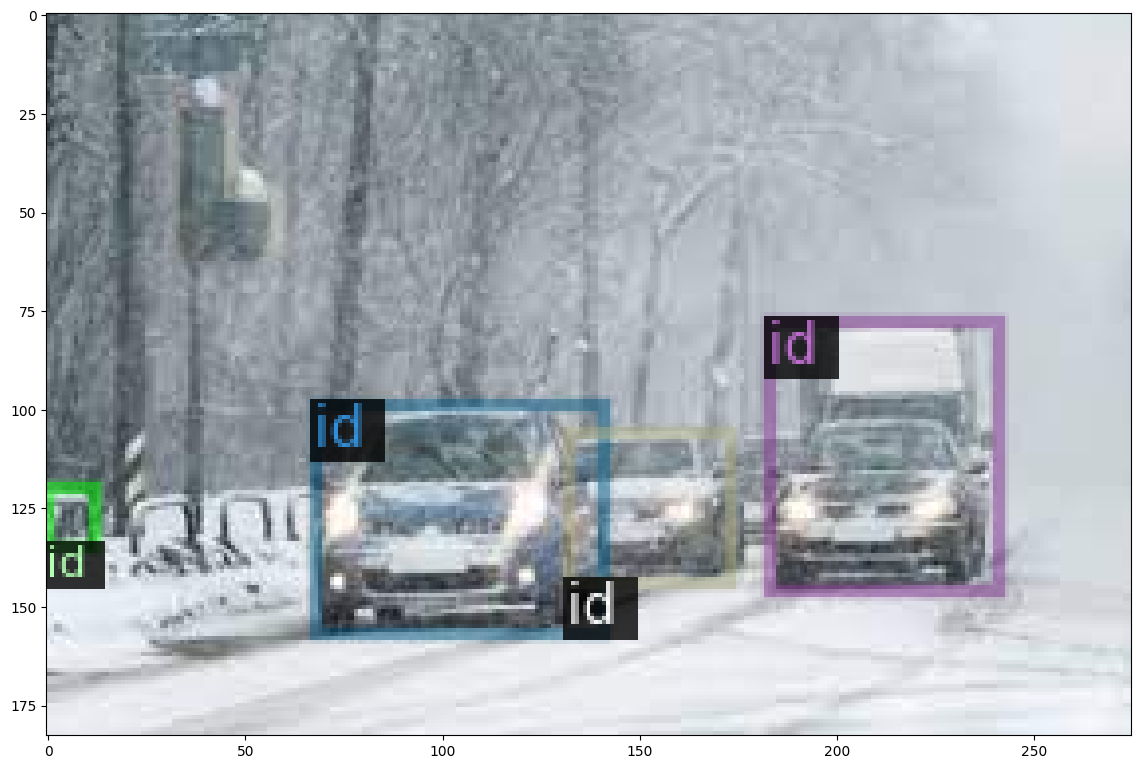

In [104]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
v_pred = v_pred.overlay_instances(
    boxes= predictions.pred_boxes.tensor.detach().cpu(),
    #labels = labels
    labels = ["ood " if i==1 else "id " for i in predictions.pred_classes]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [22]:
coco_pred = coco_model([inputs])[0]
coco_pred

{'instances': Instances(num_instances=2, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[481.7670, 276.1406, 503.3987, 288.8317],
         [230.8313, 189.2358, 249.1873, 206.3574]], device='cuda:0',
        grad_fn=<IndexBackward0>)), scores: tensor([0.9002, 0.8621], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([ 2, 11], device='cuda:0')])}

In [ ]:
coco_boxes,coco_ood_pred = pred_instances.pred_boxes[len(coco_pred['instances'])],pred_instances.pred_classes

In [16]:
outputs

{'instances': Instances(num_instances=7, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[230.9155, 188.4200, 248.0668, 206.6877],
         [656.4849, 177.0030, 752.2354, 437.9042],
         [340.6237, 229.9380, 417.2627, 423.4198],
         [173.4544, 263.6410, 218.7826, 273.8240],
         [483.5026, 277.3364, 503.1032, 288.6660],
         [112.9023, 287.2609, 150.2943, 304.7575],
         [411.1407, 251.6891, 457.8786, 293.5152]], device='cuda:0')), scores: tensor([0.9674, 0.8863, 0.8342, 0.7955, 0.7912, 0.7516, 0.5533],
        device='cuda:0'), pred_classes: tensor([9, 7, 7, 2, 2, 2, 1], device='cuda:0')])}

In [17]:
from torchvision.ops import box_iou

In [18]:
box_iou(outputs['instances'].pred_boxes.tensor,id_pred['instances'].pred_boxes.tensor)

tensor([[0.0000, 0.0000, 0.8697],
        [0.0000, 0.0000, 0.0000],
        [0.0138, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.8425, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], device='cuda:0')

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


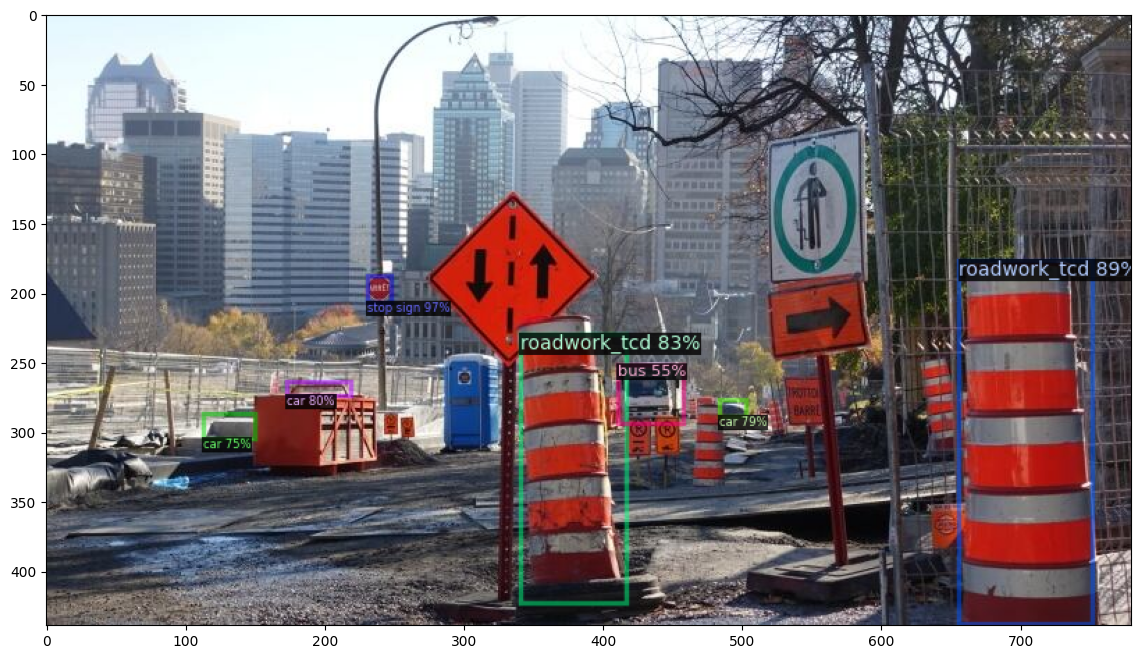

In [48]:
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [66]:
labels = [" " for i in range(len(coco_pred['instances']))]
things_classes = np.array(["bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"])
addon = things_classes[list(outputs['instances'].pred_classes.cpu())]
for i in range(len(addon)):
    labels.append(addon[i]+" "+"{:1.2f}".format(float(outputs['instances'].scores.cpu()[i])))

In [67]:
labels

[' ',
 ' ',
 'stop sign 0.97',
 'roadwork_tcd 0.89',
 'roadwork_tcd 0.83',
 'car 0.80',
 'car 0.79',
 'car 0.75',
 'bus 0.55']

In [53]:
list(outputs['instances'].pred_classes.cpu())

[tensor(9), tensor(7), tensor(7), tensor(2), tensor(2), tensor(2), tensor(1)]

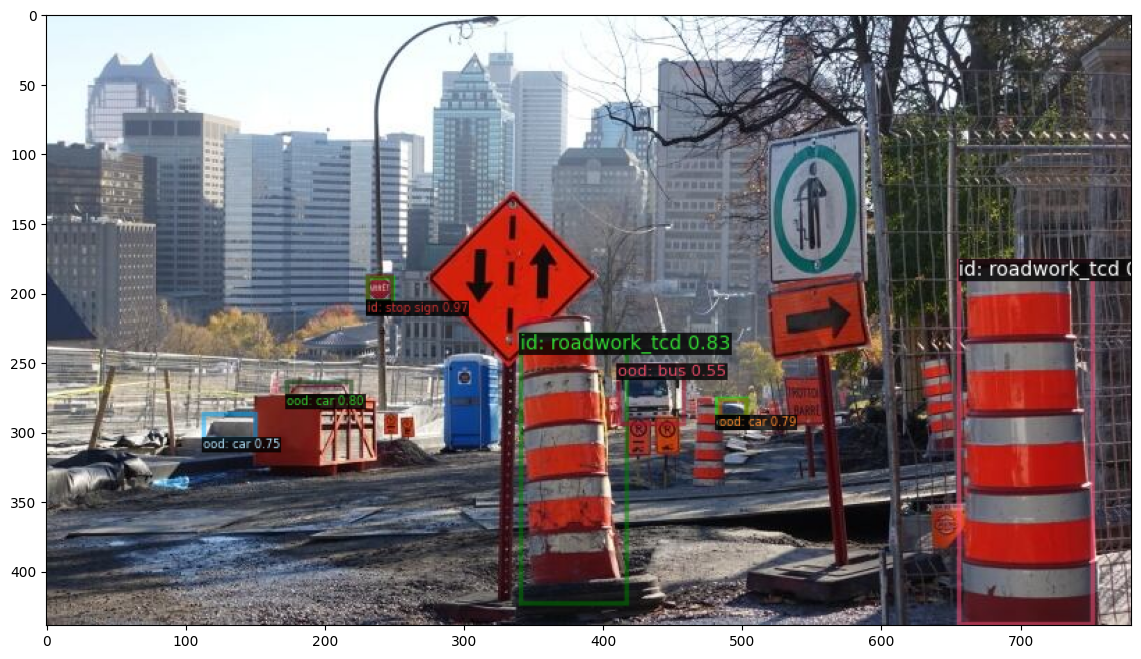

In [68]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
v_pred = v_pred.overlay_instances(
    boxes= pred_instances.pred_boxes.tensor.detach().cpu(),
    #labels = labels
    labels = ["ood: "+score if i==0 else "id: "+score for i,score in zip(pred_instances.pred_classes,labels)]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image())

In [13]:
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog

In [77]:
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml")
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"
predictor = DefaultPredictor(cfg)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [78]:
cfg.MODEL.WEIGHTS

'/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth'

In [81]:
outputs

{'instances': Instances(num_instances=1, image_height=168, image_width=299, fields=[pred_boxes: Boxes(tensor([[190.4978,  31.5227, 237.4825, 142.8364]], device='cuda:0')), scores: tensor([0.5660], device='cuda:0'), pred_classes: tensor([223], device='cuda:0')])}

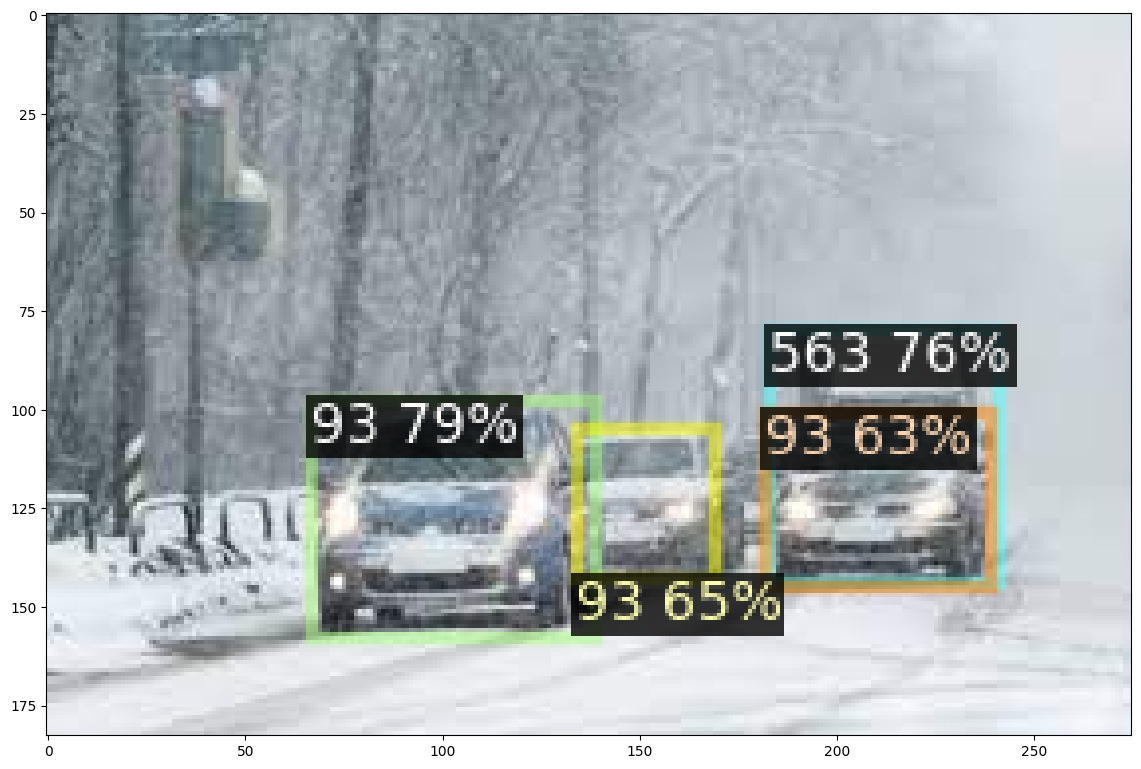

In [100]:
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1], None)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [110]:
coco_pred = coco_model([inputs])[0]
coco_pred

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


{'instances': Instances(num_instances=2, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[ 68.2683,  96.9002, 139.9266, 157.8318],
         [129.6717, 105.1422, 175.2438, 145.1434]], device='cuda:0',
        grad_fn=<IndexBackward0>)), scores: tensor([0.6026, 0.5134], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([93, 93], device='cuda:0')])}

In [86]:
torch.concat([prop_boxes,prop_boxes],dim=0)

tensor([[752.2924, 450.6546, 764.9667, 481.3219],
        [439.0278, 473.5027, 538.8801, 564.3167],
        [437.5882, 472.5216, 539.8032, 563.6158],
        [752.2924, 450.6546, 764.9667, 481.3219],
        [439.0278, 473.5027, 538.8801, 564.3167],
        [437.5882, 472.5216, 539.8032, 563.6158]], device='cuda:0')

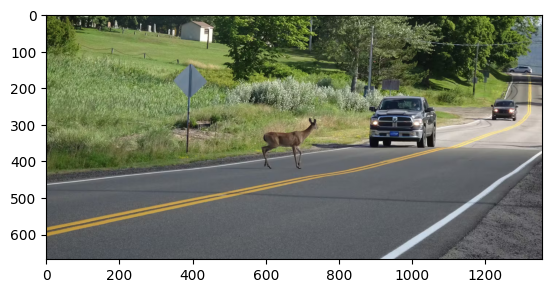

In [53]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [38]:
Mahalanobis = []
inp_image,h,w= inputs['image'],inputs['height'],inputs['width']
    #gt = input['instances'].gt_boxes.tensor.to(device)
    #gt = input['']
    ### the backward graph settings             
inp_image = inp_image.to(device=device).to(dtype=torch.float32).requires_grad_(True)   

im = {"image": inp_image, "height": h, "width": w}
prop_boxes = torch.concat([coco_pred['instances'].pred_boxes.tensor.detach(),outputs['instances'].pred_boxes.tensor.detach()],dim=0)

prop_boxes,out_features,predictions = get_features(model,im,prop_boxes,is_inference=False)
    #prop_boxes,out_features = get_features(model,im,gt)    

gaussian_score = 0
out_features = torch.unsqueeze(out_features,1)
sample_mean = torch.unsqueeze(sample_mean,0)
zero_f = out_features - sample_mean     #shape b,n_c,1024
### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
### taking diag() of (n_c,n_c) matrices
gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
gaussian_score = -0.5*gaussian_score.sum(dim=-1)

### there's no need to calculate again as its the same calculation
loss = -(gaussian_score).max(dim=1)[0]

for l in range(len(loss)):
    if l == len(loss) - 1:
        model.zero_grad()
        inp_image.grad = None
        loss[l].backward()
    else:
        model.zero_grad()
        inp_image.grad = None
        loss[l].backward(retain_graph=True)
    ### sign function on gradients
    gradient =  torch.ge(inp_image.grad, 0)
    gradient = (gradient.float() - 0.5) * 2

    ### scaling the gradient by image preprocessing std in original code, 
    ### not needed as its 1 in FasterRCNN, subject to specific case

    # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
    # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
    # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))

    tempInputs = torch.add(inp_image, -magnitude, gradient)

    with torch.no_grad():

        _,noise_out_features,_ = get_features(copy_model,{"image": tempInputs, "height": h, "width": w},prop_boxes)

        noise_gaussian_score = 0
        noise_out_features = torch.unsqueeze(noise_out_features[l],0)
        noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
        ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
        noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()

        noise_gaussian_score = torch.max(noise_gaussian_score)
        Mahalanobis.append(noise_gaussian_score.cpu().numpy())

ood_preds = torch.tensor(np.asarray(Mahalanobis)) < -10000.0
pred_instances = Instances((h,w))
pred_instances.pred_boxes = Boxes(prop_boxes)
pred_instances.pred_classes = ood_preds*1
pred_instances.mahal_scores = torch.tensor(np.asarray(Mahalanobis))

In [37]:
sample_mean = sample_mean.squeeze()

In [44]:
coco_pred['instances'],pred_instances,outputs['instances']

(Instances(num_instances=2, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[481.7670, 276.1406, 503.3987, 288.8317],
         [230.8313, 189.2358, 249.1873, 206.3574]], device='cuda:0',
        grad_fn=<IndexBackward0>)), scores: tensor([0.9002, 0.8621], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([ 2, 11], device='cuda:0')]),
 Instances(num_instances=9, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[481.7670, 276.1406, 503.3987, 288.8317],
         [230.8313, 189.2358, 249.1873, 206.3574],
         [230.9155, 188.4200, 248.0668, 206.6877],
         [656.4849, 177.0030, 752.2354, 437.9042],
         [340.6237, 229.9380, 417.2627, 423.4198],
         [173.4544, 263.6410, 218.7826, 273.8240],
         [483.5026, 277.3364, 503.1032, 288.6660],
         [112.9023, 287.2609, 150.2943, 304.7575],
         [411.1407, 251.6891, 457.8786, 293.5152]], device='cuda:0')), pred_classes: tensor([0, 1, 1, 1, 1, 0, 0, 0, 0]), mahal_scor